In [1]:
import string
import warnings
from itertools import product
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from numpy.random import exponential, normal

warnings.simplefilter(action="ignore", category=UserWarning)

notebook_tic = time()

gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 103

---

## Model 2. Multiple genes hierarchical model with one covariate

Model the logFC of multiple genes in multiple cell lines using a single predictor: RNA expression.
A hierarchcial model will be used to pool information across genes.

$
logFC \sim Normal(\mu, \sigma) \\
\mu_g = \alpha_g + \beta_g R \\
\quad \alpha_g \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\qquad \mu_\alpha \sim \mathcal{N}(0, 10) \quad \sigma_\alpha \sim \text{HalfNormal}(5) \\
\quad \beta_g \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\qquad \mu_\beta \sim \mathcal{N}(0, 10) \quad \sigma_\beta \sim \text{HalfNormal}(5) \\
\sigma \sim \text{HalfNormal}(5)
$

Simulated values:

- number of cell lines: 30
- number of genes: 5
- $\mu_\alpha = -1$, $\sigma_\alpha = 1$
- $\mu_\beta = -1$, $\sigma_\beta = 2$
- $\sigma = 0.3$

In [2]:
np.random.seed(RANDOM_SEED)

num_cell_lines = 30
num_genes = 5

real_mu_alpha, real_sigma_alpha = -1, 1
real_mu_beta, real_sigma_beta = -1, 2
real_sigma = 0.5

real_alpha = np.random.normal(loc=real_mu_alpha, scale=real_sigma_alpha, size=num_genes)
real_beta = np.random.normal(loc=real_mu_beta, scale=real_sigma_beta, size=num_genes)

genes = ["gene" + a for a in string.ascii_uppercase[:num_genes]]
rna = np.random.randn(num_genes, num_cell_lines)

logfc = (
    real_alpha
    + real_beta * rna.T
    + np.random.normal(loc=0, scale=real_sigma, size=(rna.T.shape))
)
logfc = logfc.T

In [3]:
rna_flat = rna.flatten()
logfc_flat = logfc.flatten()
gene_idx = np.repeat(range(num_genes), num_cell_lines)

The following plot shows that each gene has a different y-intercept and slope with RNA expression.
These varying effects should be discovered by the model.

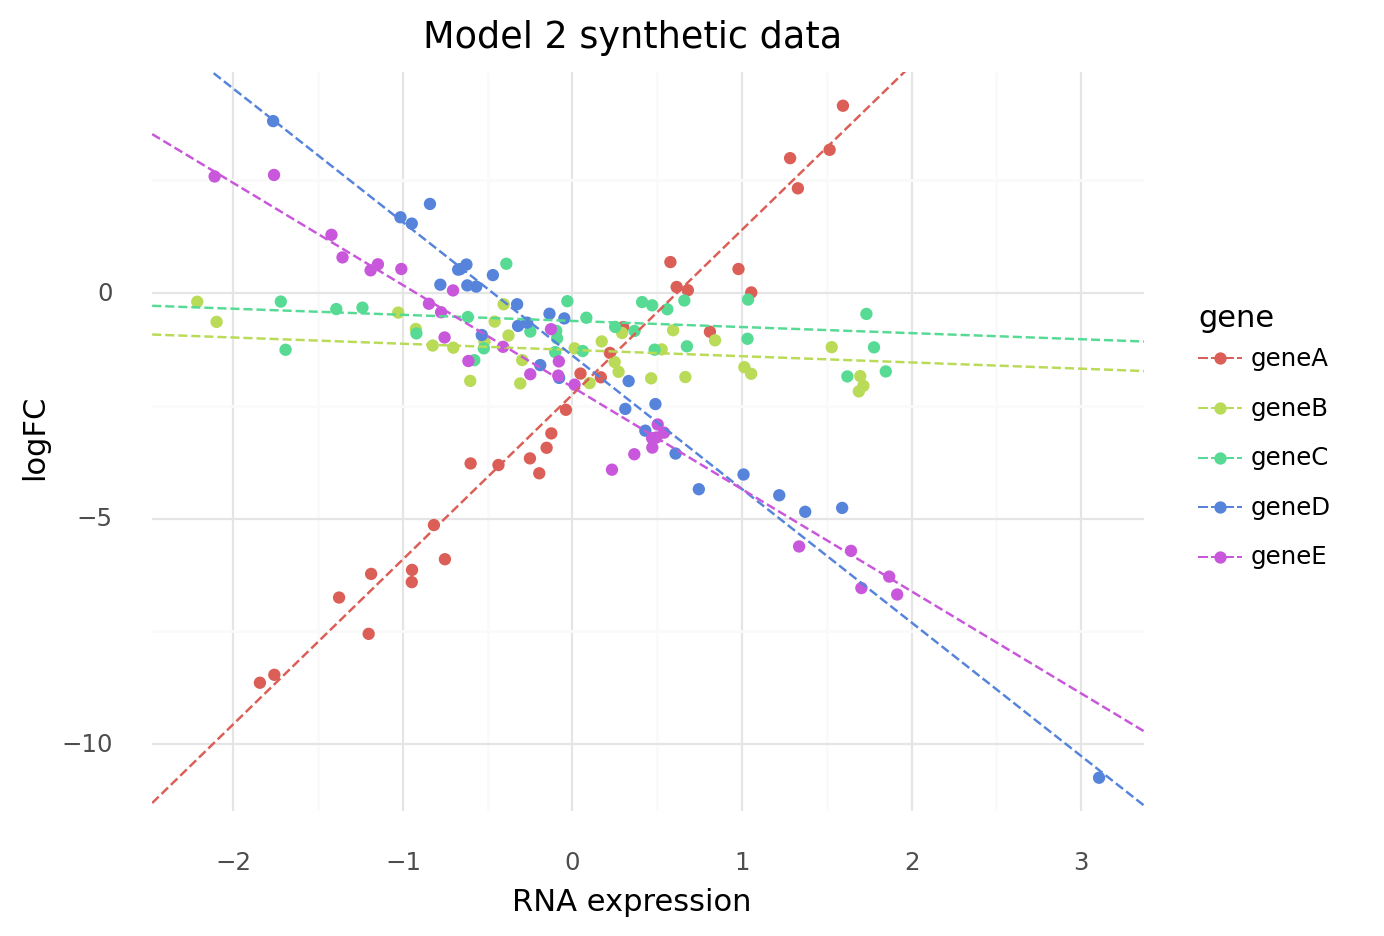

<ggplot: (8730080151974)>

In [4]:
tidy_data = pd.DataFrame(
    {"gene": [genes[i] for i in gene_idx], "rna": rna_flat, "logfc": logfc_flat}
)

tidy_real_data = pd.DataFrame({"alpha": real_alpha, "beta": real_beta, "gene": genes})


(
    gg.ggplot(tidy_data)
    + gg.geom_point(gg.aes(x="rna", y="logfc", color="gene"))
    + gg.geom_abline(
        gg.aes(slope="beta", intercept="alpha", color="gene"),
        data=tidy_real_data,
        linetype="--",
    )
    + gg.labs(
        x="RNA expression", y="logFC", color="gene", title="Model 2 synthetic data"
    )
)

In [5]:
with pm.Model() as model2:
    # Hyper-priors
    mu_alpha = pm.Normal("mu_alpha", 0, 5)
    sigma_alpha = pm.HalfNormal("sigma_alpha", 5)
    mu_beta = pm.Normal("mu_beta", 0, 2)
    sigma_beta = pm.HalfNormal("sigma_beta", 2)

    # Priors
    alpha = pm.Normal("alpha", mu_alpha, sigma_alpha, shape=num_genes)
    beta = pm.Normal("beta", mu_beta, sigma_beta, shape=num_genes)
    mu = pm.Deterministic("mu", alpha[gene_idx] + beta[gene_idx] * rna_flat)
    sigma = pm.HalfNormal("sigma", 5)

    # Likelihood
    logfc = pm.Normal("logfc", mu=mu, sigma=sigma, observed=logfc_flat)

    # Sampling
    model2_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model2_trace = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED)
    model2_post_check = pm.sample_posterior_predictive(
        model2_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


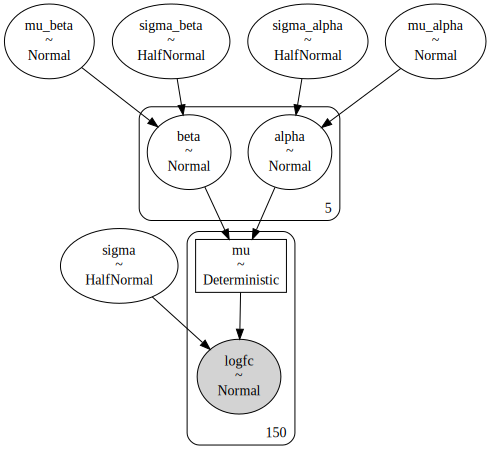

In [6]:
pm.model_to_graphviz(model2)

In [7]:
az_model2 = az.from_pymc3(
    trace=model2_trace,
    prior=model2_prior_check,
    posterior_predictive=model2_post_check,
    model=model2,
)
az.summary(az_model2, var_names=["alpha", "beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-2.416,0.098,-2.601,-2.232,0.001,0.001,14337.0,14337.0,14303.0,5579.0,1.0
alpha[1],-1.272,0.099,-1.450,-1.084,0.001,0.001,13215.0,13130.0,13190.0,6015.0,1.0
alpha[2],-0.763,0.100,-0.949,-0.575,0.001,0.001,12696.0,12280.0,12649.0,5904.0,1.0
alpha[3],-1.378,0.097,-1.564,-1.202,0.001,0.001,14732.0,14579.0,14710.0,5790.0,1.0
alpha[4],-2.148,0.098,-2.326,-1.961,0.001,0.001,12961.0,12961.0,12946.0,5307.0,1.0
beta[0],3.585,0.103,3.394,3.780,0.001,0.001,14890.0,14890.0,14914.0,6262.0,1.0
beta[1],-0.354,0.098,-0.536,-0.167,0.001,0.001,14280.0,12995.0,14336.0,6428.0,1.0
beta[2],-0.144,0.103,-0.336,0.051,0.001,0.001,14533.0,8631.0,14544.0,5872.0,1.0
beta[3],-2.839,0.100,-3.024,-2.653,0.001,0.001,12500.0,12493.0,12516.0,6081.0,1.0
beta[4],-2.359,0.093,-2.530,-2.183,0.001,0.001,13775.0,13775.0,13772.0,5490.0,1.0


In [8]:
# Real values
pd.DataFrame({"real alpha": real_alpha, "real beta": real_beta})

,real alpha,real beta
0,-2.249278,3.654438
1,-1.260331,-0.138414
2,-0.616207,-0.135368
3,-1.385461,-2.960023
4,-2.085137,-2.263930


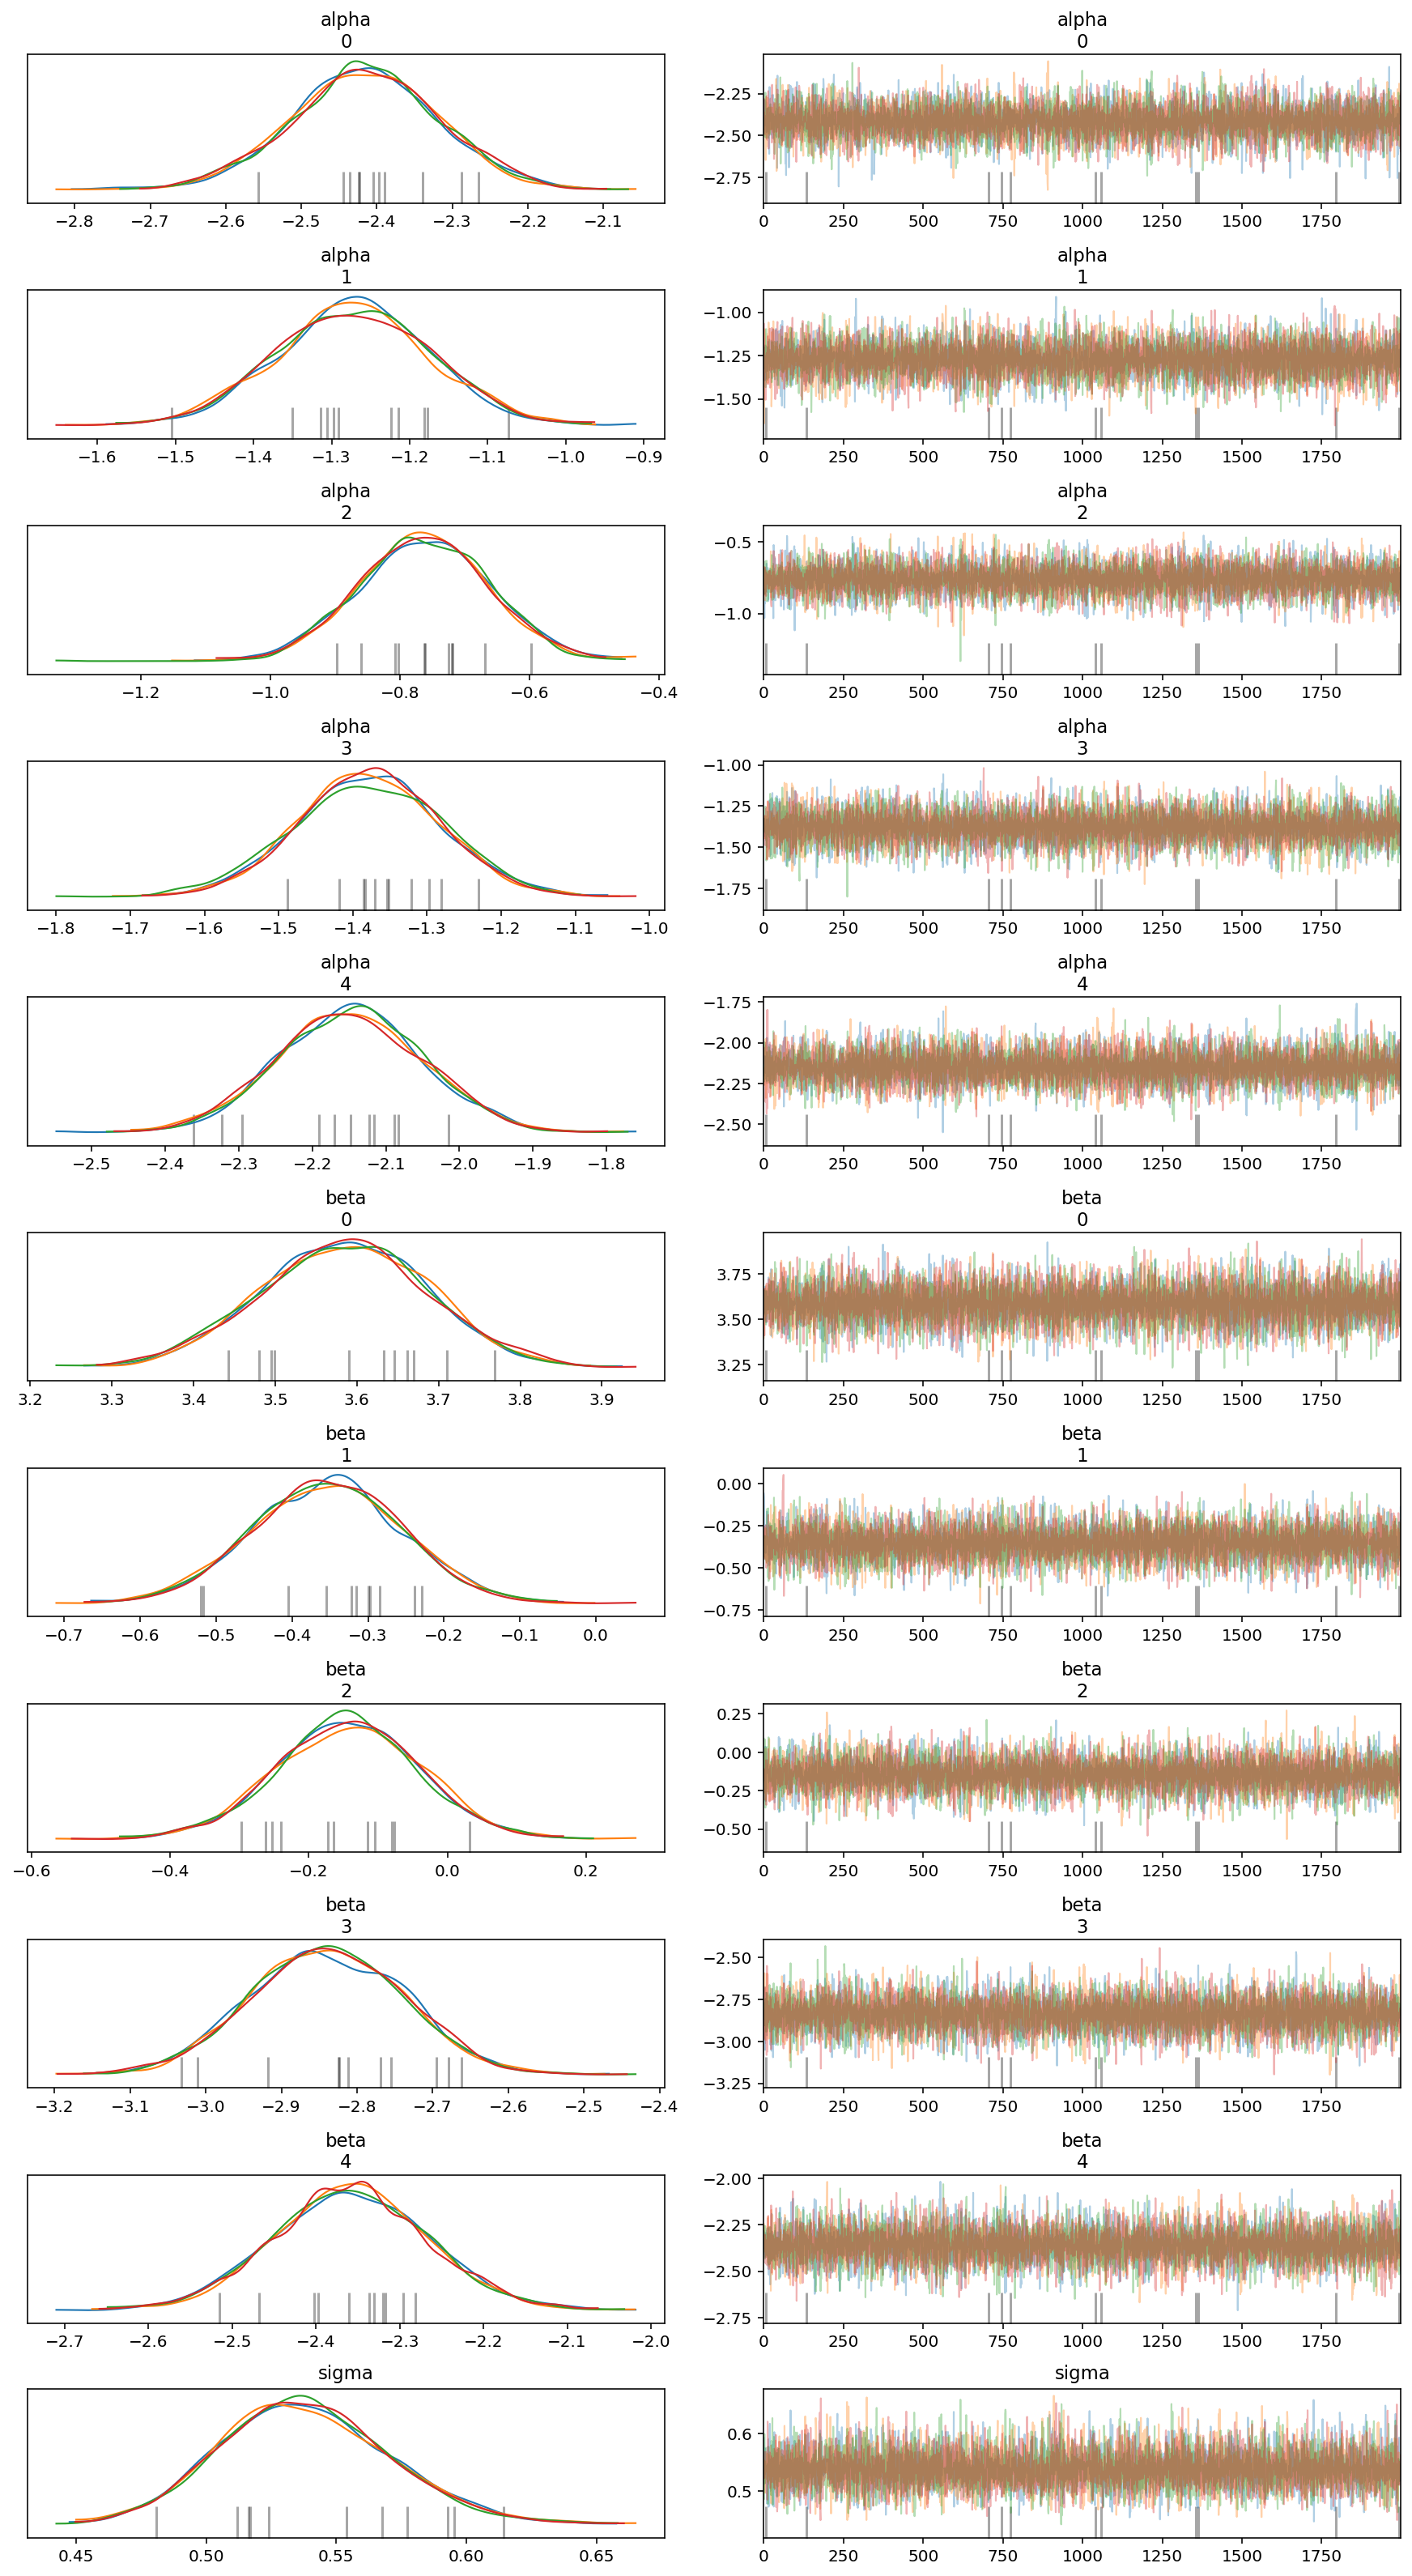

In [9]:
var_names = ["alpha", "beta", "sigma"]
az.plot_trace(az_model2, var_names=var_names)
plt.show()

The varying effects were captured *very* well.

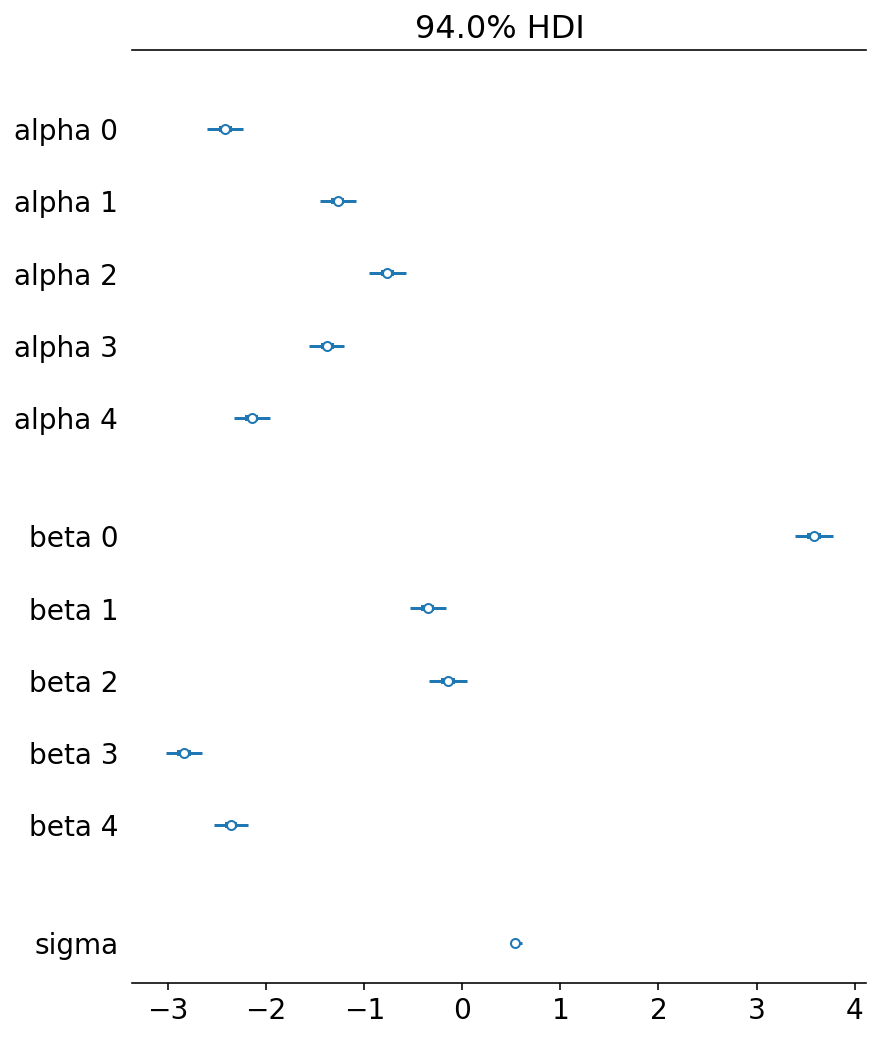

In [10]:
az.plot_forest(az_model2, var_names=var_names, combined=True)
plt.show()

In [11]:
post = (
    az_model2.posterior.to_dataframe()
    .query("alpha_dim_0 == beta_dim_0")
    .reset_index()
    .groupby(["alpha_dim_0", "beta_dim_0"])
    .apply(lambda x: x.sample(frac=0.1))
    .reset_index(drop=True)
)

In [12]:
post.head()

,alpha_dim_0,beta_dim_0,chain,draw,mu_dim_0,mu_alpha,mu_beta,alpha,beta,sigma_alpha,sigma_beta,mu,sigma
0,0,0,0,1848,13,-1.707124,1.020120,-2.519896,3.444709,0.611066,2.459867,2.703516,0.535601
1,0,0,1,416,68,-1.817120,-0.059203,-2.508976,3.610907,0.912548,2.030147,-0.713922,0.468053
2,0,0,1,749,55,-1.998970,-1.028616,-2.469391,3.367253,0.596512,2.348285,-1.320811,0.613881
3,0,0,2,702,80,-2.276971,-1.240895,-2.207284,3.553626,0.688711,2.218307,-0.889368,0.541003
4,0,0,2,1510,143,-3.419487,-0.641618,-2.376427,3.464837,1.510821,2.359916,0.303088,0.514731


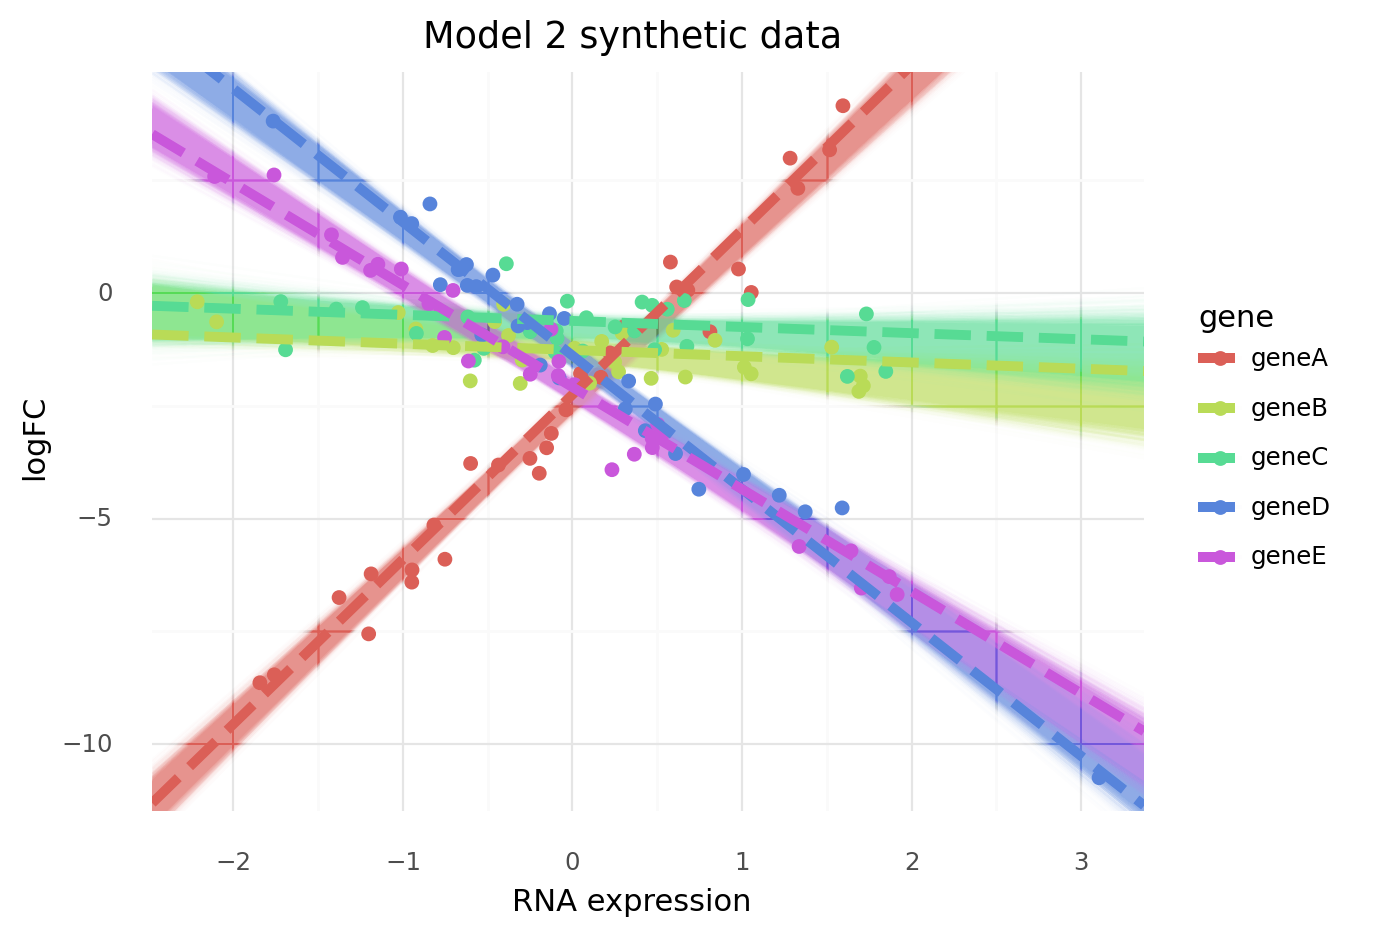

<ggplot: (8730079422937)>

In [13]:
post["gene"] = [genes[i] for i in post.alpha_dim_0]

(
    gg.ggplot(post)
    + gg.geom_abline(gg.aes(slope="beta", intercept="alpha", color="gene"), alpha=0.01)
    + gg.geom_point(gg.aes(x="rna", y="logfc", color="gene"), data=tidy_data, size=2)
    + gg.geom_abline(
        gg.aes(slope="beta", intercept="alpha", color="gene"),
        data=tidy_real_data,
        linetype="--",
        size=2,
    )
    + gg.labs(
        x="RNA expression", y="logFC", color="gene", title="Model 2 synthetic data"
    )
)

### Conclusions and final thoughts

This hierharchcial model fit very well and the results were interpretable.

---

In [14]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 1.22 minutes


In [15]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

arviz    0.10.0
numpy    1.19.2
pandas   1.1.3
plotnine 0.7.1
seaborn  0.11.0
pymc3    3.9.3
last updated: 2020-12-17 

CPython 3.8.5
IPython 7.18.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1062.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 32
interpreter: 64bit
host name  : compute-a-16-78.o2.rc.hms.harvard.edu
Git branch : subset-data
